# R2-A5-S16 Modelo de regresión o clasificación

## Estudiante: José Miguel Méndez Martín

### Ejercicio 1:

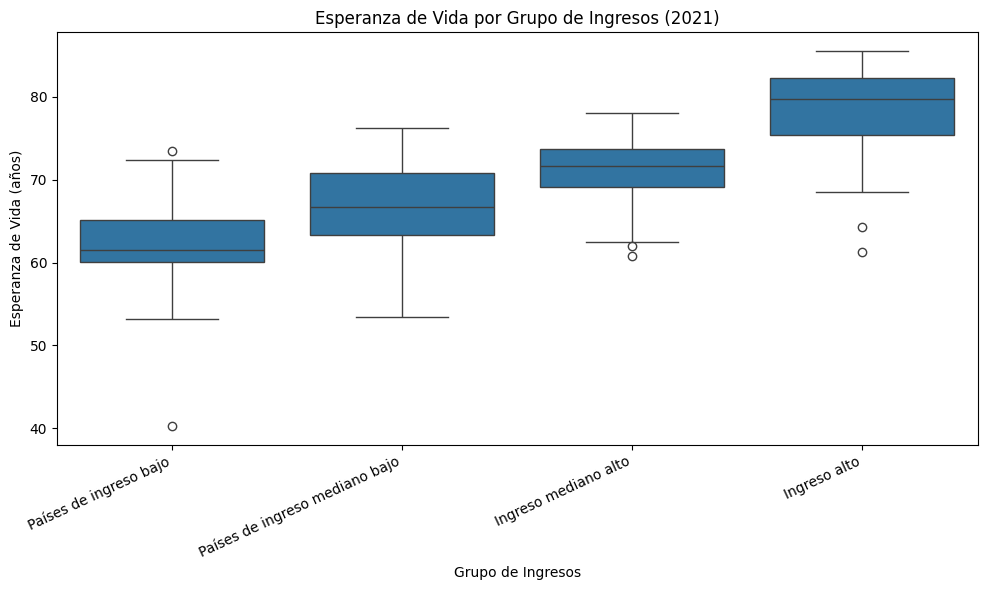

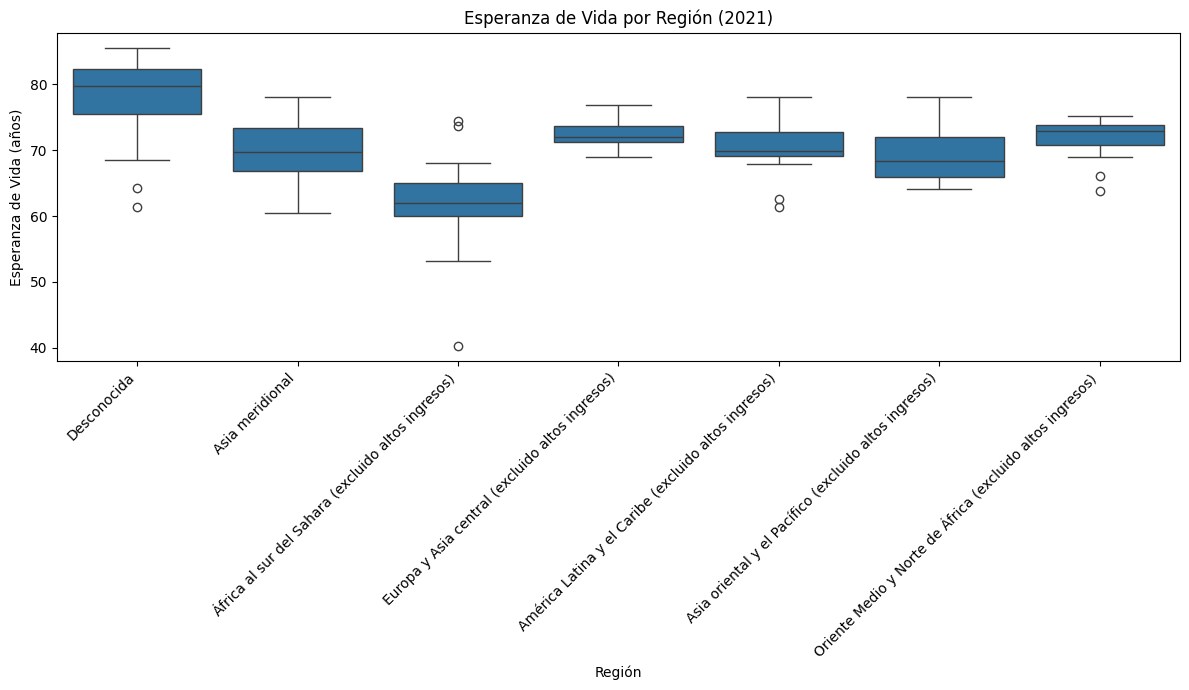

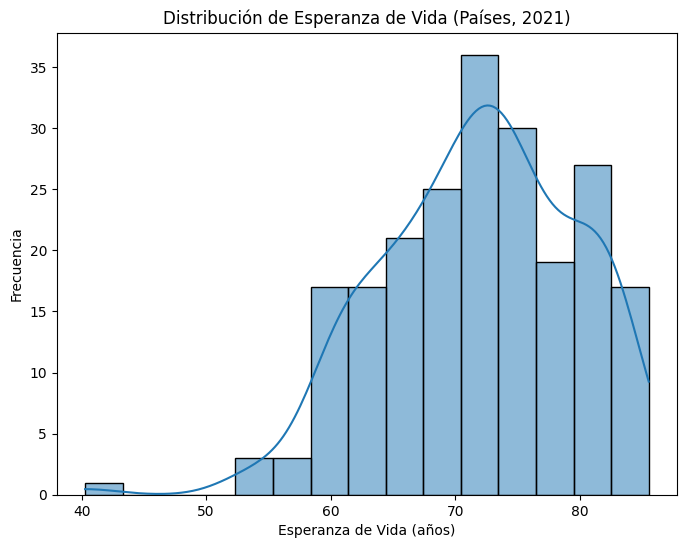

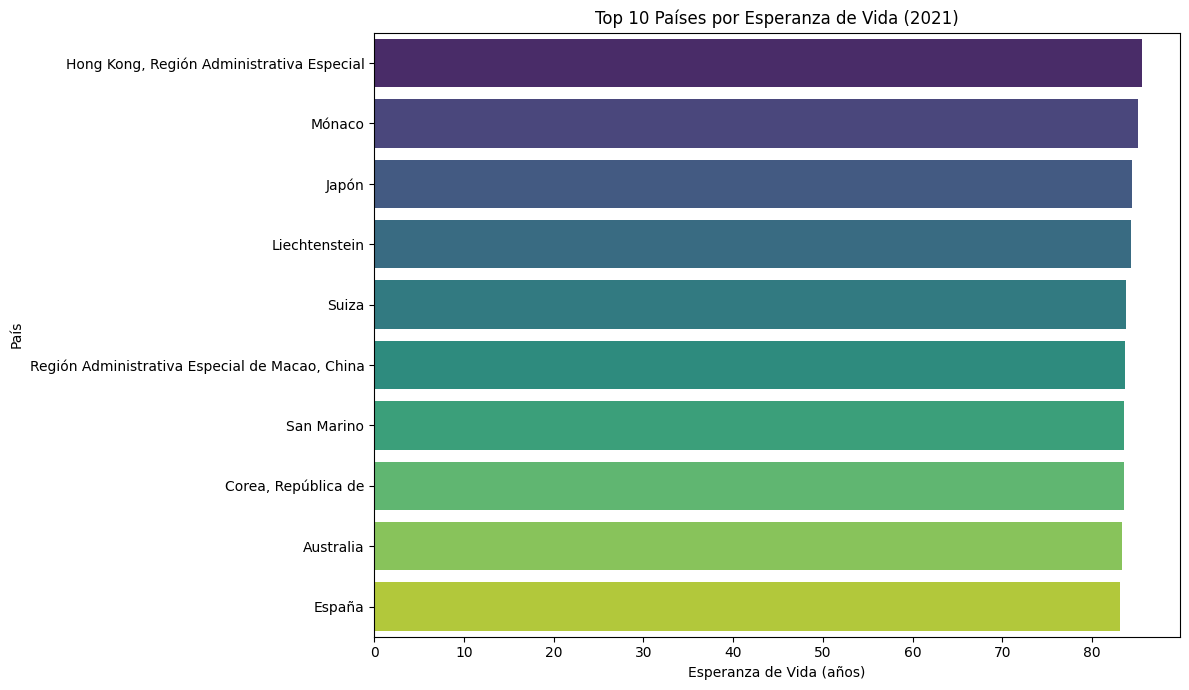

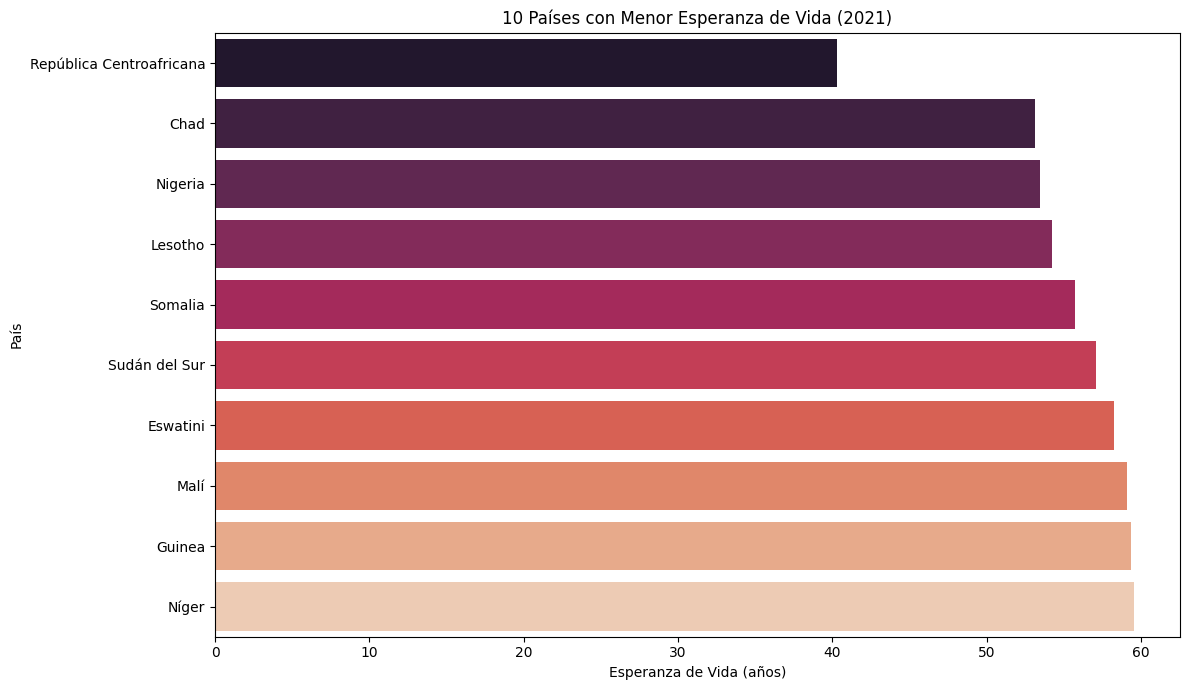

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Cargar los datos ---
# Cargar los datos de esperanza de vida
try:
    # Las primeras dos líneas de tu ejemplo son metadatos, la tercera es el encabezado
    df_life_exp_raw = pd.read_csv('../csv/API_SP.DYN.LE00.IN_DS2_es_csv_v2_86998.csv')
except FileNotFoundError:
    print("Error: 'esperanza_vida_raw.csv' no encontrado. Asegúrate de que el archivo esté en la misma carpeta o proporciona la ruta completa.")
    exit()

# Cargar los metadatos de los países (Región, Grupo de Ingresos)
try:
    df_country_meta = pd.read_csv('../csv/Metadata_Country_API_SP.DYN.LE00.IN_DS2_es_csv_v2_86998.csv')
    # Limpiar posibles espacios en blanco en los nombres de las columnas
    df_country_meta.columns = df_country_meta.columns.str.strip()
except FileNotFoundError:
    print("Error: 'country_metadata.csv' no encontrado. Asegúrate de que el archivo esté en la misma carpeta o proporciona la ruta completa.")
    exit()



# --- 2. Transformar datos de Esperanza de Vida a formato largo ---
id_vars_life_exp = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']
value_vars_life_exp = [col for col in df_life_exp_raw.columns if col not in id_vars_life_exp and col.isdigit()]

df_life_exp_long = pd.melt(df_life_exp_raw,
                           id_vars=id_vars_life_exp,
                           value_vars=value_vars_life_exp,
                           var_name='Year',
                           value_name='Life_Expectancy')

df_life_exp_long['Year'] = pd.to_numeric(df_life_exp_long['Year'])
df_life_exp_long['Life_Expectancy'] = pd.to_numeric(df_life_exp_long['Life_Expectancy'], errors='coerce')



# --- 3. Seleccionar un Año Específico ---
YEAR_TO_ANALYZE = 2021 # Elige un año reciente con datos
df_year_selected = df_life_exp_long[df_life_exp_long['Year'] == YEAR_TO_ANALYZE].copy()
df_year_selected = df_year_selected[['Country Name', 'Country Code', 'Life_Expectancy']] # Solo columnas necesarias



# --- 4. Limpiar df_country_meta y Fusionar ---
# Eliminar filas en df_country_meta donde 'Country Name' o 'Country Code' es NaN, si las hay
df_country_meta.dropna(subset=['Country Name', 'Country Code'], inplace=True)
# Seleccionar columnas relevantes de metadatos
df_country_meta = df_country_meta[['Country Name', 'Country Code', 'Region', 'Income_Group']]

df_merged = pd.merge(df_year_selected, df_country_meta, on=['Country Name', 'Country Code'], how='left')



# --- 5. Manejar Valores Faltantes en el DataFrame Fusionado ---
# Importante: Eliminar filas donde la Esperanza de Vida es NaN
df_merged.dropna(subset=['Life_Expectancy'], inplace=True)

# Para 'Region' e 'Income_Group', puedes rellenar NaNs con "Desconocido" o eliminar esas filas
# Aquí los rellenaremos para no perder países si solo falta esta info categórica
df_merged['Region'] = df_merged['Region'].fillna('Desconocida')
df_merged['Income_Group'] = df_merged['Income_Group'].fillna('Desconocido')

# Filtrar agregados (ej. donde Income_Group es 'Agregados' o Region está vacía o es 'Desconocida' si eso identifica agregados)
# Basado en tus datos, parece que los agregados tienen 'Income_Group' vacío o no especificado
# Los países con 'Country Code' como AFE, AFW, ARB también son agregados.
# Una forma más robusta sería tener una lista de códigos de agregados o filtrar por 'Income_Group' no siendo uno de los grupos de ingreso de países.
# Por ahora, vamos a filtrar donde 'Income_Group' NO es 'Agregados' (si es que existe esa categoría)
# Y donde 'Region' no sea 'Desconocida' si eso implica un agregado
# Y donde 'Country Code' no sea uno de los códigos de agregados conocidos (AFE, AFW, ARB...)
known_aggregate_codes = ['AFE', 'AFW', 'ARB', 'CEA', 'CEB', 'ECS', 'EMU', 'EUU', 'FCS', 'HIC', 'HPC', 'IBD', 'IBT', 'IDA', 'IDX', 'LAC', 'LCN', 'LDC', 'LIC', 'LMC', 'LMY', 'LTE', 'MEA', 'MIC', 'MNA', 'NAC', 'OED', 'OSS', 'PRE', 'PSS', 'PST', 'SAS', 'SSA', 'SSF', 'SST', 'TEA', 'TEC', 'TLA', 'TMN', 'TSA', 'UMC', 'WLD'] # Lista incompleta, necesitas revisar los datos del Banco Mundial
df_countries_only = df_merged[~df_merged['Country Code'].isin(known_aggregate_codes)].copy()

# También filtrar por filas donde 'Income_Group' podría indicar un agregado (ej. si contiene la palabra 'aggregate')
if 'Income_Group' in df_countries_only.columns:
     df_countries_only = df_countries_only[~df_countries_only['Income_Group'].str.contains('aggregate', case=False, na=False)]
     # Filtrar para asegurar que Income_Group sea uno de los válidos (ej. 'Ingreso alto', 'Países de ingreso bajo', etc.)
     valid_income_groups = ['Ingreso alto', 'Países de ingreso bajo', 'Países de ingreso mediano bajo', 'Ingreso mediano alto'] # Ajusta según tus datos
     df_countries_only = df_countries_only[df_countries_only['Income_Group'].isin(valid_income_groups)]



if df_countries_only.empty:
    print(f"No quedan datos de países después de filtrar para el año {YEAR_TO_ANALYZE}. Revisa los filtros o el año.")
    exit()

# --- 6. ¡TU PRIMER OBJETO VISUAL! ---
# Por ejemplo, Esperanza de Vida promedio por Grupo de Ingresos

plt.figure(figsize=(10, 6))
sns.boxplot(x='Income_Group', y='Life_Expectancy', data=df_countries_only,
            order=['Países de ingreso bajo', 'Países de ingreso mediano bajo', 'Ingreso mediano alto', 'Ingreso alto']) # Ordenar categorías
plt.title(f'Esperanza de Vida por Grupo de Ingresos ({YEAR_TO_ANALYZE})')
plt.xlabel('Grupo de Ingresos')
plt.ylabel('Esperanza de Vida (años)')
plt.xticks(rotation=25, ha='right') # Rotar etiquetas para mejor lectura
plt.tight_layout() # Ajustar layout para que todo quepa
plt.show()

# --- SEGUNDO OBJETO VISUAL ---
# Esperanza de Vida promedio por Región
plt.figure(figsize=(12, 7))
sns.boxplot(x='Region', y='Life_Expectancy', data=df_countries_only)
plt.title(f'Esperanza de Vida por Región ({YEAR_TO_ANALYZE})')
plt.xlabel('Región')
plt.ylabel('Esperanza de Vida (años)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- TERCER OBJETO VISUAL ---
# Histograma de Esperanza de Vida para los países seleccionados
plt.figure(figsize=(8, 6))
sns.histplot(df_countries_only['Life_Expectancy'], kde=True, bins=15)
plt.title(f'Distribución de Esperanza de Vida (Países, {YEAR_TO_ANALYZE})')
plt.xlabel('Esperanza de Vida (años)')
plt.ylabel('Frecuencia')
plt.show()

# --- CUARTO OBJETO VISUAL (Ejemplo) ---
# Países con mayor esperanza de vida
top_10_life_exp = df_countries_only.nlargest(10, 'Life_Expectancy')
plt.figure(figsize=(12, 7))
sns.barplot(x='Life_Expectancy', y='Country Name', hue='Country Name', data=top_10_life_exp, palette='viridis', legend=False)
plt.title(f'Top 10 Países por Esperanza de Vida ({YEAR_TO_ANALYZE})')
plt.xlabel('Esperanza de Vida (años)')
plt.ylabel('País')
plt.tight_layout()
plt.show()

# --- QUINTO OBJETO VISUAL (Ejemplo) ---
# Países con menor esperanza de vida
bottom_10_life_exp = df_countries_only.nsmallest(10, 'Life_Expectancy')
plt.figure(figsize=(12, 7))
sns.barplot(x='Life_Expectancy', y='Country Name', hue='Country Name', data=bottom_10_life_exp, palette='rocket', legend=False)
plt.title(f'10 Países con Menor Esperanza de Vida ({YEAR_TO_ANALYZE})')
plt.xlabel('Esperanza de Vida (años)')
plt.ylabel('País')
plt.tight_layout()
plt.show()

### Seccion 2: 

Modelo de regresión

=== RESULTADOS REGRESIÓN LINEAL ===
MSE: 36.97
R²: 0.390
MAE: 5.35


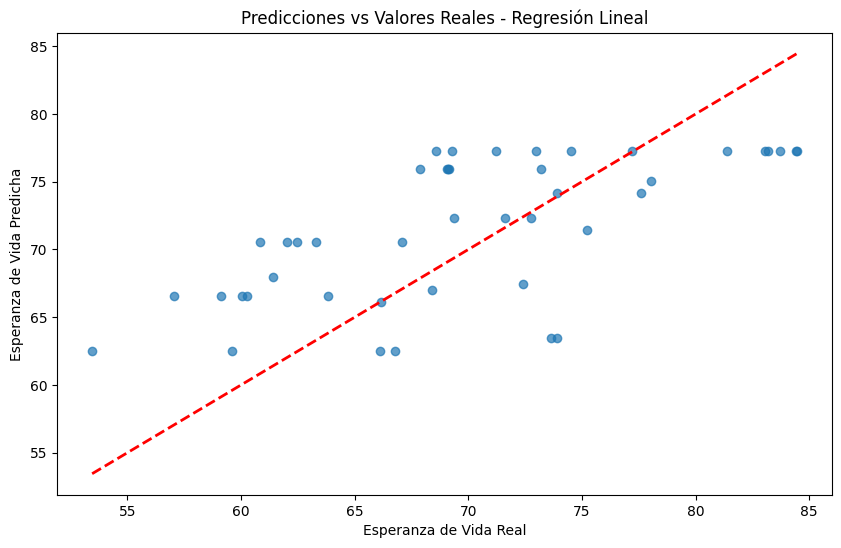


=== RESULTADOS RANDOM FOREST ===
MSE: 25.81
R²: 0.574
MAE: 4.36


In [11]:

# Agregar imports para machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- SECCIÓN 2: MODELO DE REGRESIÓN ---

# 1. Preparar datos para regresión
# Codificar variables categóricas
le_region = LabelEncoder()
le_income = LabelEncoder()

df_model = df_countries_only.copy()
df_model['Region_encoded'] = le_region.fit_transform(df_model['Region'])
df_model['Income_Group_encoded'] = le_income.fit_transform(df_model['Income_Group'])

# 2. Definir características (X) y variable objetivo (y)
X = df_model[['Region_encoded', 'Income_Group_encoded']]
y = df_model['Life_Expectancy']

# 3. Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Crear y entrenar modelo de regresión lineal
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# 5. Hacer predicciones
y_pred_lr = model_lr.predict(X_test)

# 6. Evaluar modelo
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print("=== RESULTADOS REGRESIÓN LINEAL ===")
print(f"MSE: {mse_lr:.2f}")
print(f"R²: {r2_lr:.3f}")
print(f"MAE: {mae_lr:.2f}")

# 7. Visualizar resultados
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Esperanza de Vida Real')
plt.ylabel('Esperanza de Vida Predicha')
plt.title('Predicciones vs Valores Reales - Regresión Lineal')
plt.show()

# 8. Modelo alternativo: Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

# Evaluar Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("\n=== RESULTADOS RANDOM FOREST ===")
print(f"MSE: {mse_rf:.2f}")
print(f"R²: {r2_rf:.3f}")
print(f"MAE: {mae_rf:.2f}")

# 9. Comparación de modelos
comparison_data = {
    'Modelo': ['Regresión Lineal', 'Random Forest'],
    'MSE': [mse_lr, mse_rf],
    'R²': [r2_lr, r2_rf],
    'MAE': [mae_lr, mae_rf]
}

df_comparison = pd.DataFrame(comparison_data)

### Seccion 3:

Modelo de clasificación

=== RESULTADOS REGRESIÓN LOGÍSTICA ===
Precisión: 0.545

Reporte de clasificación:
                                precision    recall  f1-score   support

                  Ingreso alto       0.68      0.88      0.77        17
          Ingreso mediano alto       0.57      0.36      0.44        11
        Países de ingreso bajo       0.38      0.60      0.46         5
Países de ingreso mediano bajo       0.29      0.18      0.22        11

                      accuracy                           0.55        44
                     macro avg       0.48      0.51      0.47        44
                  weighted avg       0.52      0.55      0.52        44



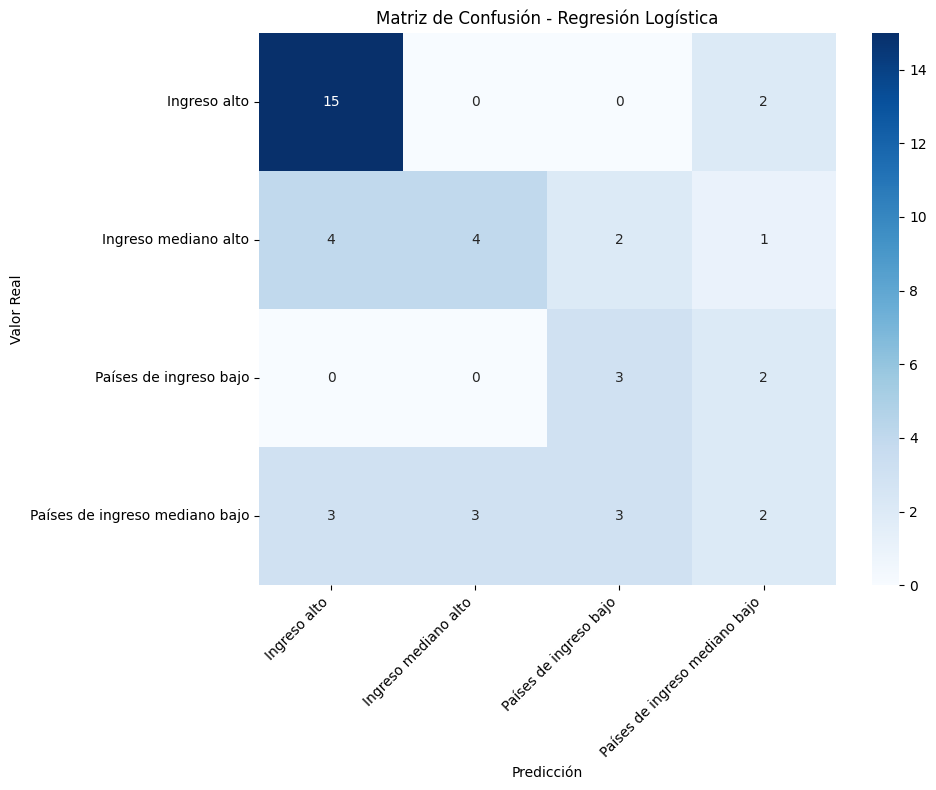


=== RESULTADOS RANDOM FOREST CLASIFICACIÓN ===
Precisión: 0.614

Reporte de clasificación:
                                precision    recall  f1-score   support

                  Ingreso alto       0.89      1.00      0.94        17
          Ingreso mediano alto       0.60      0.27      0.38        11
        Países de ingreso bajo       0.00      0.00      0.00         5
Países de ingreso mediano bajo       0.44      0.64      0.52        11

                      accuracy                           0.61        44
                     macro avg       0.48      0.48      0.46        44
                  weighted avg       0.61      0.61      0.59        44



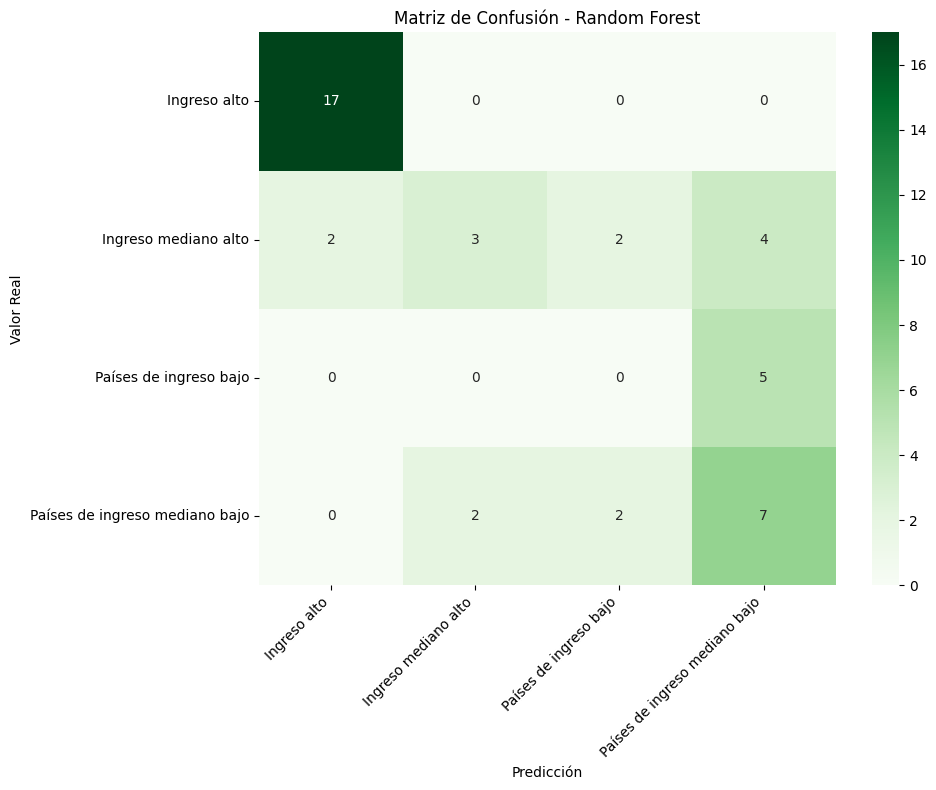


=== COMPARACIÓN DE MODELOS DE CLASIFICACIÓN ===
                Modelo  Precisión
0  Regresión Logística   0.545455
1        Random Forest   0.613636


C:\Users\josem\AppData\Local\Temp\ipykernel_11416\2112706132.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=classification_comparison, x='Modelo', y='Precisión', palette='viridis')


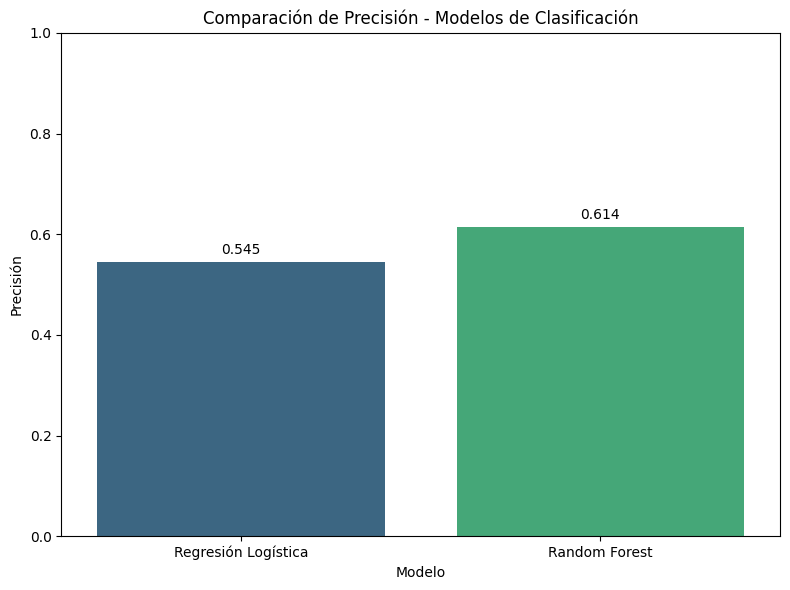

C:\Users\josem\AppData\Local\Temp\ipykernel_11416\2112706132.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='rocket')


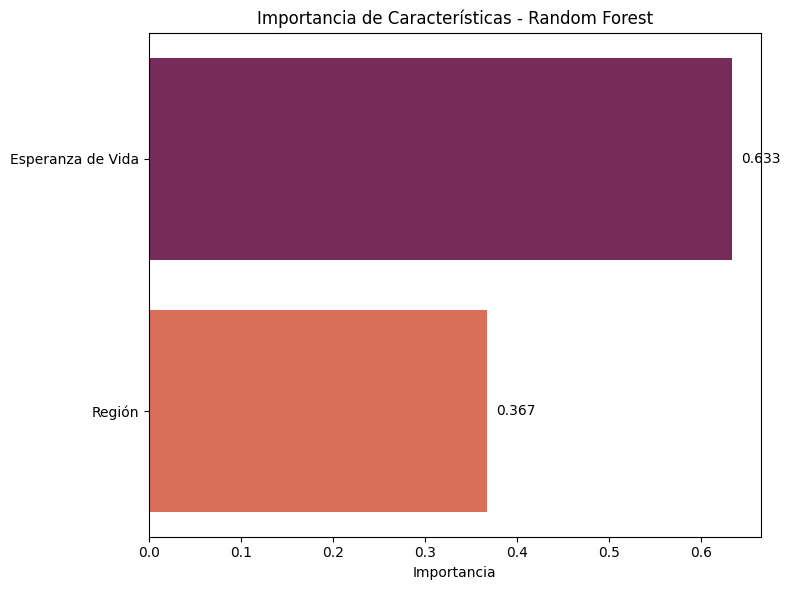

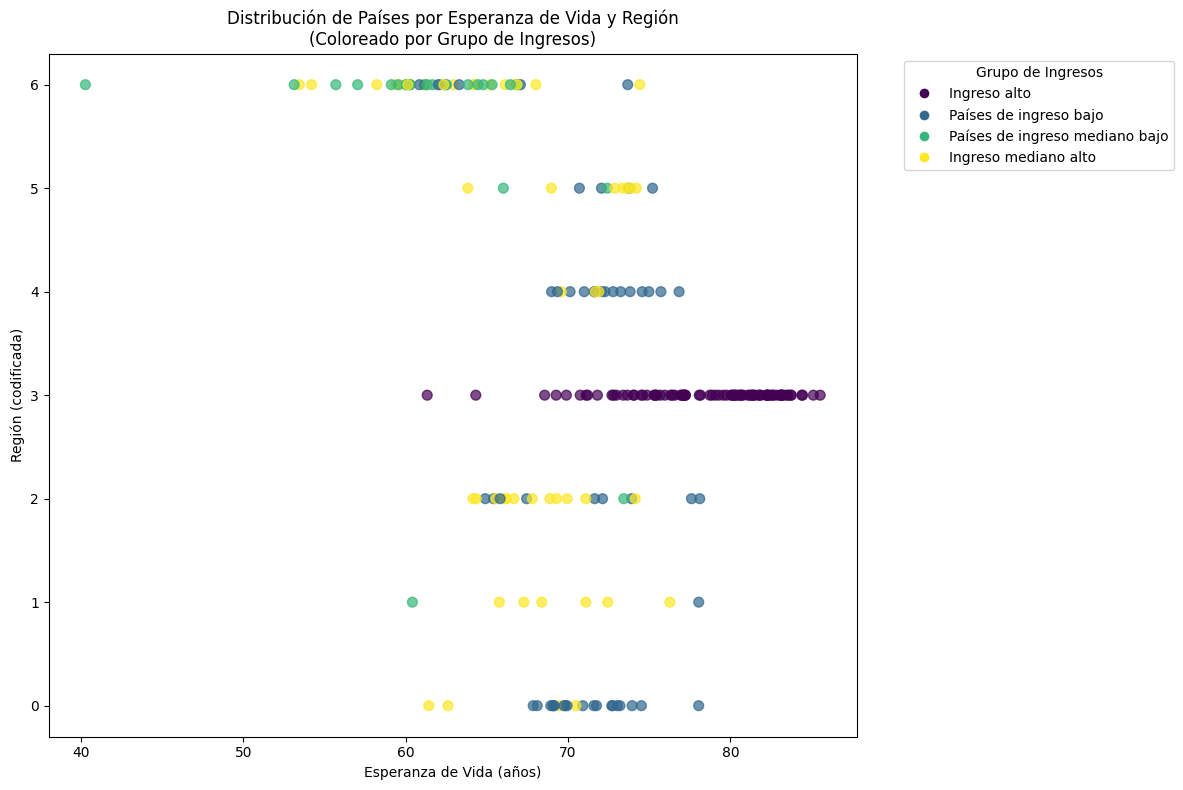

In [12]:

# --- SECCIÓN 3: MODELO DE CLASIFICACIÓN ---

# Agregar imports adicionales para clasificación
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# 1. Preparar datos para clasificación
# Usaremos Esperanza de Vida y Región para predecir Income_Group
df_classification = df_countries_only.copy()

# Codificar la región para el modelo de clasificación
le_region_class = LabelEncoder()
df_classification['Region_encoded'] = le_region_class.fit_transform(df_classification['Region'])

# 2. Definir características (X) y variable objetivo (y) para clasificación
X_class = df_classification[['Life_Expectancy', 'Region_encoded']]
y_class = df_classification['Income_Group']

# 3. Dividir datos en entrenamiento y prueba
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# 4. Escalar las características para mejorar el rendimiento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_class)
X_test_scaled = scaler.transform(X_test_class)

# 5. Crear y entrenar modelo de clasificación - Regresión Logística
model_log = LogisticRegression(random_state=42, max_iter=1000)
model_log.fit(X_train_scaled, y_train_class)

# 6. Hacer predicciones
y_pred_log = model_log.predict(X_test_scaled)

# 7. Evaluar modelo de regresión logística
accuracy_log = accuracy_score(y_test_class, y_pred_log)
print("=== RESULTADOS REGRESIÓN LOGÍSTICA ===")
print(f"Precisión: {accuracy_log:.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test_class, y_pred_log))

# 8. Matriz de confusión para regresión logística
plt.figure(figsize=(10, 8))
cm_log = confusion_matrix(y_test_class, y_pred_log)
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model_log.classes_, 
            yticklabels=model_log.classes_)
plt.title('Matriz de Confusión - Regresión Logística')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 9. Modelo alternativo: Random Forest para clasificación
model_rf_class = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf_class.fit(X_train_class, y_train_class)  # RF no necesita escalado
y_pred_rf_class = model_rf_class.predict(X_test_class)

# 10. Evaluar Random Forest para clasificación
accuracy_rf = accuracy_score(y_test_class, y_pred_rf_class)
print("\n=== RESULTADOS RANDOM FOREST CLASIFICACIÓN ===")
print(f"Precisión: {accuracy_rf:.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test_class, y_pred_rf_class))

# 11. Matriz de confusión para Random Forest
plt.figure(figsize=(10, 8))
cm_rf = confusion_matrix(y_test_class, y_pred_rf_class)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=model_rf_class.classes_, 
            yticklabels=model_rf_class.classes_)
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 12. Comparación de modelos de clasificación
classification_comparison = pd.DataFrame({
    'Modelo': ['Regresión Logística', 'Random Forest'],
    'Precisión': [accuracy_log, accuracy_rf]
})

print("\n=== COMPARACIÓN DE MODELOS DE CLASIFICACIÓN ===")
print(classification_comparison)

# 13. Gráfico de comparación de precisión
plt.figure(figsize=(8, 6))
sns.barplot(data=classification_comparison, x='Modelo', y='Precisión', palette='viridis')
plt.title('Comparación de Precisión - Modelos de Clasificación')
plt.ylabel('Precisión')
plt.ylim(0, 1)
for i, v in enumerate(classification_comparison['Precisión']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# 14. Importancia de características (solo para Random Forest)
if hasattr(model_rf_class, 'feature_importances_'):
    feature_names = ['Esperanza de Vida', 'Región']
    importances = model_rf_class.feature_importances_
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=importances, y=feature_names, palette='rocket')
    plt.title('Importancia de Características - Random Forest')
    plt.xlabel('Importancia')
    for i, v in enumerate(importances):
        plt.text(v + 0.01, i, f'{v:.3f}', va='center')
    plt.tight_layout()
    plt.show()

# 15. Visualización de predicciones por esperanza de vida
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_classification['Life_Expectancy'], 
                     df_classification['Region_encoded'], 
                     c=pd.Categorical(df_classification['Income_Group']).codes, 
                     cmap='viridis', alpha=0.7, s=50)
plt.xlabel('Esperanza de Vida (años)')
plt.ylabel('Región (codificada)')
plt.title('Distribución de Países por Esperanza de Vida y Región\n(Coloreado por Grupo de Ingresos)')

# Crear leyenda personalizada
income_groups = df_classification['Income_Group'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(income_groups)))
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=colors[i], markersize=8, 
                             label=group) for i, group in enumerate(income_groups)]
plt.legend(handles=legend_elements, title='Grupo de Ingresos', 
          bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()